Descriptive statistics and count of seller by location using LLM models

In [21]:
file_path = '/Users/vishalsehgal/Documents/Masters/Data Forensics/DFProject-1/crawler/crawler/output/AVCrawler/sellers.csv'

/Users/vishalsehgal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Count of Sellers by Location (Top 20):
location
United States                 898
United Kingdom                271
Indonesia                     250
India                         219
Germany                       219
Pakistan                      180
Philippines                   176
Egypt                         171
Turkey                        170
Canada                        123
Bangladesh                    110
France                        108
Lagos, Lagos, Nigeria          50
Malaysia                       50
Russia                         26
Ukraine                        25
Poland                         25
Romania                        24
Helsinki, Uusimaa, Finland     24
Brasil                         23
Name: count, dtype: int64


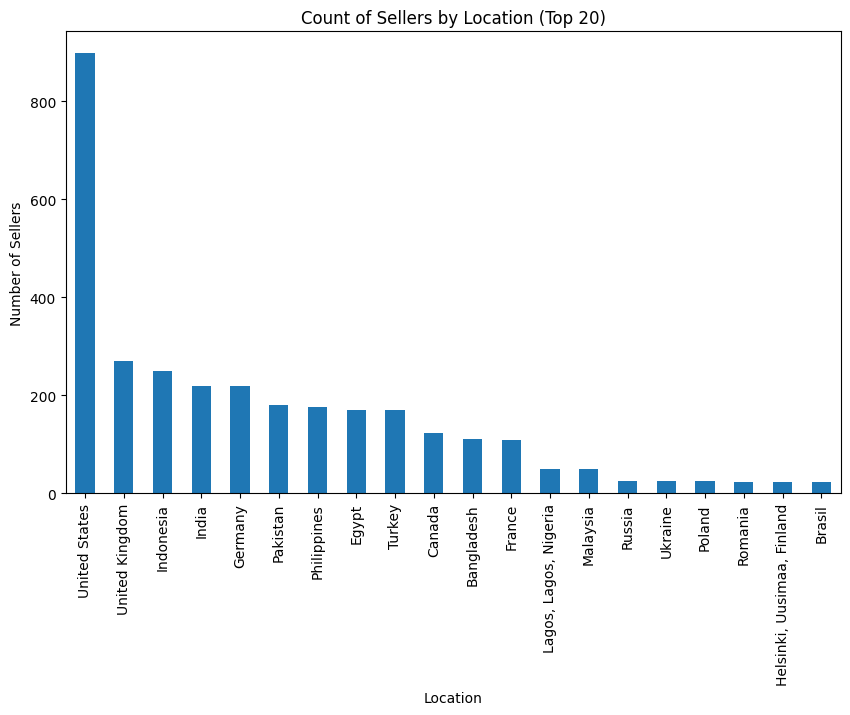

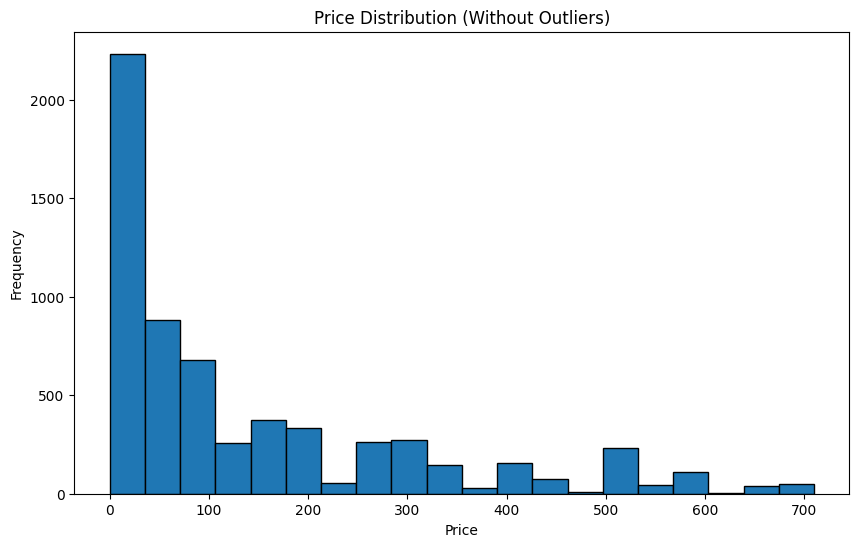

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset
file_path = '/Users/vishalsehgal/Documents/Masters/Data Forensics/DFProject-1/crawler/crawler/output/AVCrawler/sellers.csv'
sellers_df = pd.read_csv(file_path)

# Convert price to numeric, forcing non-numeric values to NaN, then drop NaN values
sellers_df['price'] = pd.to_numeric(sellers_df['price'], errors='coerce')
sellers_df = sellers_df.dropna(subset=['price'])

# Removing outliers using the IQR method
Q1 = sellers_df['price'].quantile(0.25)
Q3 = sellers_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = sellers_df[(sellers_df['price'] >= lower_bound) & (sellers_df['price'] <= upper_bound)]

# Example data for known locations to compare against
known_locations = [
    "United States", "Indonesia", "Philippines", "India", "Germany", "Egypt",
    "United Kingdom", "Pakistan", "Canada", "Turkey", "France", "Bangladesh", "Malaysia"
]

# Fit the TF-IDF vectorizer on the known locations
vectorizer = TfidfVectorizer()
known_location_vectors = vectorizer.fit_transform(known_locations)

# Initialize geolocator
geolocator = Nominatim(user_agent="location_standardizer")

# Function to standardize location names using geolocation and cosine similarity
def standardize_location(location):
    location = location.strip().title()
    if location in known_locations:
        return location
    
    # Geolocation lookup
    try:
        geo_location = geolocator.geocode(location, language='en')
        if geo_location:
            address = geo_location.address
            # Extract country
            country = address.split(",")[-1].strip()
            # Use cosine similarity to match country names
            country_vector = vectorizer.transform([country])
            similarities = cosine_similarity(country_vector, known_location_vectors).flatten()
            max_similarity_index = similarities.argmax()
            if similarities[max_similarity_index] > 0.6:
                return known_locations[max_similarity_index]
    except:
        pass
    
    # Transform the input location using the fitted vectorizer
    location_vector = vectorizer.transform([location])
    
    # Calculate cosine similarity between the input location and known locations
    similarities = cosine_similarity(location_vector, known_location_vectors).flatten()
    
    # Find the index of the most similar known location
    max_similarity_index = similarities.argmax()
    
    # If the highest similarity score is above a threshold, return the most similar known location
    if similarities[max_similarity_index] > 0.6:
        return known_locations[max_similarity_index]
    else:
        return location

# Apply the standardization function using .loc to avoid SettingWithCopyWarning
filtered_df.loc[:, 'location'] = filtered_df['location'].apply(standardize_location)

# Filter out unspecified and poorly formatted locations
filtered_locations = filtered_df[filtered_df['location'].notnull() & 
                                (filtered_df['location'] != 'Location Not Specified') & 
                                (filtered_df['location'] != ', ,')]

# Count of sellers by location
sellers_by_location = filtered_locations['location'].value_counts().head(20)  # Display top 20 locations for readability
print("\nCount of Sellers by Location (Top 20):")
print(sellers_by_location)

# Plot the count of sellers by location (Top 20)
plt.figure(figsize=(10, 6))
sellers_by_location.plot(kind='bar')
plt.title('Count of Sellers by Location (Top 20)')
plt.xlabel('Location')
plt.ylabel('Number of Sellers')
plt.xticks(rotation=90)
plt.show()

# Plot histogram of price distribution without outliers
plt.figure(figsize=(10, 6))
filtered_df['price'].plot(kind='hist', bins=20, edgecolor='black')
plt.title('Price Distribution (Without Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


To find exact locations, saved in exact_locations and vague location file

In [12]:
import pandas as pd
import re

# Load the CSV file
file_path = '/Users/vishalsehgal/Documents/Masters/Data Forensics/DFProject-1/crawler/crawler/output/AVCrawler/sellers.csv'  # Update this path to the location of your CSV file
sellers_df = pd.read_csv(file_path)

# Refine the function to identify exact locations
def has_exact_location(location):
    if pd.isna(location):
        return False
    # Check for the presence of street names, house numbers, or similar address components
    street_patterns = [
        r'\d{1,4}\s+\w+\s(street|st|road|rd|avenue|ave|boulevard|blvd|lane|ln|drive|dr|plaza|plz|circle|cir|court|ct|parkway|pkwy|trail|trl)\b',  # Common street suffixes
        r'\b(no\.|number|#)\s*\d+',  # Matches patterns like 'No. 123' or 'Number 123' or '#123'
        r'\d{1,4}\s+\w+',  # Matches patterns like '1234 StreetName'
        r'\b(block|sector|phase)\s*\d+',  # Matches patterns like 'Block 123' or 'Sector 123' or 'Phase 1'
        r'\d{5}',  # Matches patterns like ZIP codes
    ]
    return any(re.search(pattern, location, re.IGNORECASE) for pattern in street_patterns)

# Apply the refined function to categorize the locations
sellers_df['exact_location'] = sellers_df['location'].apply(has_exact_location)

# Separate the dataframe into two: one for exact locations and one for vague locations
exact_locations_df = sellers_df[sellers_df['exact_location'] == True]
vague_locations_df = sellers_df[sellers_df['exact_location'] == False]

# Save the dataframes to CSV files
exact_locations_df.to_csv('exact_locations.csv', index=False)
vague_locations_df.to_csv('vague_locations.csv', index=False)

# Print the head of each dataframe for verification
print("Exact Locations:")
print(exact_locations_df.head())

print("\nVague Locations:")
print(vague_locations_df.head())


Exact Locations:
                                                 title price       seller  \
168                                the gt : "SCORE 1O"    25         T3MX   
185                          25 Xbox prepaid gift card    16        Amz93   
190  8 ball pool higher level account with legendar...   100    Ebad khan   
772        Steam account for sale 9yo 160 games lvl 34   440  Unnamed7892   
887                   The seven deadly sins grandcross   150  notimus0410   

                                             location facebook telegram  \
168                                24 inchcape avenue      NaN      NaN   
185                                             16438      NaN      NaN   
190  Pakistan karachi Gulshan e maymar sector t3 a154      NaN      NaN   
772                      Sector 6, București, Romania      NaN      NaN   
887            9502 lambert cir garden grove ca 92841      NaN      NaN   

    whatsapp discord twitter line  ... steam skype twitch  psn  \
168

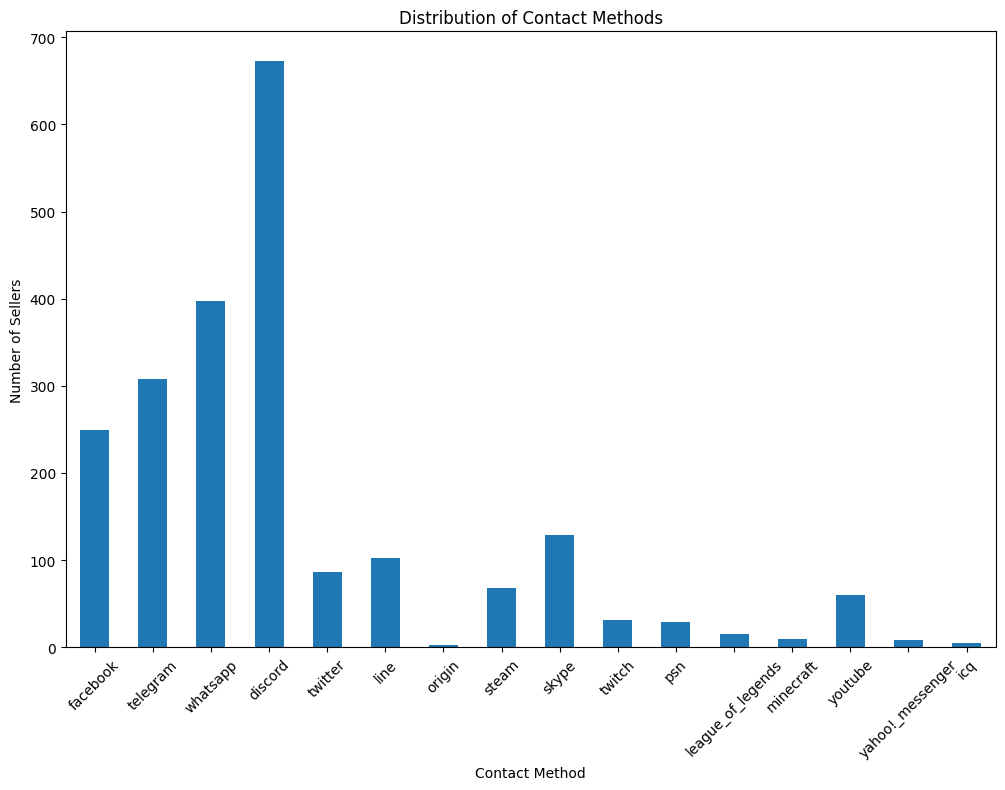

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset again since the previous dataframe is not available in this session
sellers_df = pd.read_csv(file_path)

# Convert price to numeric, forcing non-numeric values to NaN, then drop NaN values
sellers_df['price'] = pd.to_numeric(sellers_df['price'], errors='coerce')
sellers_df = sellers_df.dropna(subset=['price'])

# Removing outliers using the IQR method
Q1 = sellers_df['price'].quantile(0.25)
Q3 = sellers_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = sellers_df[(sellers_df['price'] >= lower_bound) & (sellers_df['price'] <= upper_bound)]

# Analyzing the distribution of contact methods
contact_methods = ['facebook', 'telegram', 'whatsapp', 'discord', 'twitter', 'line', 'origin', 'steam', 'skype', 'twitch', 'psn', 'league_of_legends', 'minecraft', 'youtube', 'yahoo!_messenger', 'icq']
contact_counts = filtered_df[contact_methods].notnull().sum()

# Plot the distribution of contact methods
plt.figure(figsize=(12, 8))
contact_counts.plot(kind='bar')
plt.title('Distribution of Contact Methods')
plt.xlabel('Contact Method')
plt.ylabel('Number of Sellers')
plt.xticks(rotation=45)
plt.show()


In [17]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load the dataset again since the previous dataframe is not available in this session
sellers_df = pd.read_csv(file_path)

# Convert price to numeric, forcing non-numeric values to NaN, then drop NaN values
sellers_df['price'] = pd.to_numeric(sellers_df['price'], errors='coerce')
sellers_df = sellers_df.dropna(subset=['price'])

# Removing outliers using the IQR method
Q1 = sellers_df['price'].quantile(0.25)
Q3 = sellers_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = sellers_df[(sellers_df['price'] >= lower_bound) & (sellers_df['price'] <= upper_bound)]

# Function to make product titles more generic
def make_title_generic(title):
    title = title.lower()
    title = re.sub(r'\btwitter\b', 'social media', title)
    title = re.sub(r'\bfollowers?\b', 'connections', title)
    title = re.sub(r'\bretweets?\b', 'shares', title)
    title = re.sub(r'\bfavorites?\b', 'likes', title)
    title = re.sub(r'\bcoc\b', 'game', title)
    title = re.sub(r'\bgems\b', 'resources', title)
    title = re.sub(r'\bbuy\b', 'purchase', title)
    title = re.sub(r'\bsale\b', 'for sale', title)
    return title

# Apply the function to the product titles
filtered_df['generic_title'] = filtered_df['title'].apply(lambda x: make_title_generic(str(x)))

# Display the first few rows to verify
print(filtered_df[['title', 'generic_title']].head())


                                               title  \
0                         TWITTER FAVORITES FOR SALE   
1  Twitter Followers for Sale - Buy Twitter X Fol...   
2                    TWITTER---RETWEETS---FOR---SALE   
3           ⭐ Coc Gems | No login, No ban [Verified]   
4                         TWITTER FAVORITES FOR SALE   

                                       generic_title  
0                    social media likes for for sale  
1  social media connections for for sale - purcha...  
2             social media---shares---for---for sale  
3     ⭐ game resources | no login, no ban [verified]  
4                    social media likes for for sale  


/var/folders/hd/p1cpt0jj6z5_ngrvf3vvz4tr0000gn/T/ipykernel_62608/3806409122.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['generic_title'] = filtered_df['title'].apply(lambda x: make_title_generic(str(x)))


Text classification using distilbert-base-uncased

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

# Load the dataset

sellers_df = pd.read_csv(file_path)

# Convert price to numeric, forcing non-numeric values to NaN, then drop NaN values
sellers_df['price'] = pd.to_numeric(sellers_df['price'], errors='coerce')
sellers_df = sellers_df.dropna(subset=['price'])

# Removing outliers using the IQR method
Q1 = sellers_df['price'].quantile(0.25)
Q3 = sellers_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = sellers_df[(sellers_df['price'] >= lower_bound) & (sellers_df['price'] <= upper_bound)]

# Load a pre-trained zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define potential categories
categories = ["Social Media Engagement", "Gaming", "Miscellaneous"]

# Function to categorize product titles using the model
def categorize_title(title):
    result = classifier(title, candidate_labels=categories, truncation=True)
    # Find the label with the highest score
    scores = result['scores']
    max_score_label = result['labels'][scores.index(max(scores))]
    return max_score_label

# Apply the categorization function to the product titles
filtered_df['category'] = filtered_df['title'].apply(lambda x: categorize_title(str(x)))

# Analyzing the distribution of product categories
category_counts = filtered_df['category'].value_counts()

# Plot the distribution of product categories
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar')
plt.title('Distribution of Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Sellers')
plt.xticks(rotation=45)
plt.show()

# Display the categorized dataframe
filtered_df[['title', 'category']].head()

# Save the categorized dataframe
filtered_df.to_csv('categorized_sellers.csv', index=False)

import ace_tools as tools; tools.display_dataframe_to_user(name="Categorized Sellers DataFrame", dataframe=filtered_df)


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

RuntimeError: Failed to import transformers.models.bart.modeling_tf_bart because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [28]:
pip install pandas matplotlib transformers torch


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
